In [27]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pyvis.network import Network
from pyvis.options import Layout

In [28]:
def phi(f, alpha):
    return 1 - (1-f)**alpha

In [246]:
@dataclass
class Block:
    id: int
    slot: int
    height: int
    weight: int
    parent: int
    refs: list[int]
    leader: int

In [247]:
@dataclass
class NetworkParams:
    mixnet_delay_mean: int # seconds
    mixnet_delay_var: int
    broadcast_delay_mean: int # second
    pol_proof_time: int # seconds
    no_network_delay: bool = False

    def sample_mixnet_delay(self):
        scale = self.mixnet_delay_var / self.mixnet_delay_mean
        shape = self.mixnet_delay_mean / scale
        return np.random.gamma(shape=shape, scale=scale)
    
    def sample_broadcast_delay(self, blocks):
        return np.random.exponential(self.broadcast_delay_mean, size=blocks.shape)

    def block_arrival_slot(self, block_slot):
        if self.no_network_delay:
            return block_slot
        return self.pol_proof_time + self.sample_mixnet_delay() + self.sample_broadcast_delay(block_slot) + block_slot

In [248]:
@dataclass
class Params:
    SLOTS: int
    f: float
    honest_stake: np.array
    adversary_control: float

    @property
    def N(self):
        return len(self.honest_stake) + 1

    @property
    def stake(self):
        return np.append(self.honest_stake, self.honest_stake.sum() / (1/self.adversary_control - 1))
    
    @property
    def relative_stake(self):
        return self.stake / self.stake.sum()

    def slot_prob(self):
        return phi(self.f, self.relative_stake)

In [269]:
class Sim:
    def __init__(self, params: Params, network: NetworkParams):
        self.params = params
        self.network = network
        self.leaders = np.zeros((params.N, params.SLOTS), dtype=np.int64)
        self.blocks = []
        self.block_slots = np.array([], dtype=np.int64)
        self.block_weights = np.array([], dtype=np.int64)
        self.block_heights = np.array([], dtype=np.int64)
        self.block_arrivals = np.zeros(shape=(params.N, 0), dtype=np.int64) # arrival time to each leader for each block

        # emit the genesis block
        self.emit_block(
            leader=0,
            slot=0,
            height=1,
            weight=1,
            parent=-1,
            refs=[]
        )
        self.block_arrivals[:,:] = 0 # all nodes see the genesis block

    def emit_block(self, leader, slot, weight, height, parent, refs):
        assert type(leader) in [int, np.int64]
        assert type(slot) in [int, np.int64]
        assert type(weight) in [int, np.int64]
        assert type(height) in [int, np.int64]
        assert type(parent) in [int, np.int64]
        assert all(type(r) in [int, np.int64] for r in refs)

        block = Block(
            id=len(self.blocks),
            slot=slot,
            weight=weight,
            height=height,
            parent=parent,
            refs=refs,
            leader=leader,
        )
        self.blocks.append(block)
        self.block_slots = np.append(self.block_slots, block.slot)
        self.block_weights = np.append(self.block_weights, block.weight)
        self.block_heights = np.append(self.block_heights, block.height)
    
        # decide when this block will arrive at each node
        new_block_arrival_by_node = self.network.block_arrival_slot(np.repeat(block.slot, self.params.N))

        if parent != -1:
            # the new block cannot arrive before it's parent
            parent_arrival_by_node = self.block_arrivals[:,parent]
            new_block_arrival_by_node = np.maximum(new_block_arrival_by_node, parent_arrival_by_node)
        
        self.block_arrivals = np.append(self.block_arrivals, new_block_arrival_by_node.reshape((self.params.N, 1)), axis=1)
        return block.id

    def emit_leader_block(self, leader, slot):
        assert type(leader) in [int, np.int64], type(leader)
        assert isinstance(slot, int)

        parent = self.fork_choice(leader, slot)
    
        refs = self.select_refs(leader, parent, slot)
        return self.emit_block(
            leader,
            slot,
            weight=self.blocks[parent].weight + len(refs) + 1,
            height=self.blocks[parent].height + 1,
            parent=parent,
            refs=refs
        )

    def fork_choice(self, node, slot) -> id:
        assert type(node) in [int, np.int64], type(node)
        assert isinstance(slot, int)

        arrived_blocks = self.block_arrivals[node] <= slot
        return (self.block_weights*arrived_blocks).argmax()

    def select_refs(self, node: int, parent: int, slot: int) -> list[id]:
        assert type(node) in [int, np.int64], node
        assert type(parent) in [int, np.int64], parent
        assert type(slot) in [int, np.int64], slot
        assert parent != -1

        parents_siblings = [s for s in self.block_siblings(node, parent, slot) if s != parent]
        # we are uniformly sampling from power_set(forks)
        return list(np.array(parents_siblings)[np.random.uniform(size=len(parents_siblings)) < 0.5])

    
    def block_siblings(self, node, block, slot):
        blocks_seen_by_node = self.block_arrivals[node,:] <= slot
        parent = self.blocks[block].parent
        if parent == -1:
            return [block]
        successor_blocks = self.block_slots > self.blocks[parent].slot
        candidate_siblings = np.nonzero(blocks_seen_by_node & successor_blocks)[0]
        return [b for b in candidate_siblings if self.blocks[b].parent == parent]

    def plot_spacetime_diagram(self, MAX_SLOT=1000):
        alpha_index = sorted(range(self.params.N), key=lambda n: self.params.relative_stake[n])
        nodes = [f"$N_{{{n}}}$($\\alpha$={self.params.relative_stake[n]:.2f})" for n in alpha_index]
        messages = [(nodes[alpha_index.index(self.blocks[b].leader)], nodes[alpha_index.index(node)], self.blocks[b].slot, arrival_slot, f"$B_{{{b}}}$") for b, arrival_slots in enumerate(self.block_arrivals[:-1,:].T) for node, arrival_slot in enumerate(arrival_slots) if arrival_slot < MAX_SLOT]
    
        fig, ax = plt.subplots(figsize=(8,4))
        
        # Plot vertical lines for each node
        max_slot = max(s for _,_,start_t, end_t,_ in messages for s in [start_t, end_t])
        for i, node in enumerate(nodes):
            ax.plot([i, i], [0, max_slot], 'k-', linewidth=0.1)
            ax.text(i, max_slot + 30 * (0 if i % 2 == 0 else 1), node, ha='center', va='bottom')
        
        # Plot messages
        colors = plt.cm.rainbow(np.linspace(0, 1, len(messages)))
        for (start, end, start_time, end_time, label), color in zip(messages, colors):
            start_idx = nodes.index(start)
            end_idx = nodes.index(end)
            ax.annotate('', xy=(end_idx, end_time), xytext=(start_idx, start_time),
                        arrowprops=dict(arrowstyle='->', color="black", lw=0.5))
            placement = 0
            mid_x = start_idx * (1 - placement) + end_idx * placement
            mid_y = start_time * (1 - placement) + end_time * placement
            ax.text(mid_x, mid_y, label, ha='center', va='center', 
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        ax.set_xlim(-1, len(nodes))
        ax.set_ylim(0, max_slot + 70)
        ax.set_xticks(range(len(nodes)))
        ax.set_xticklabels([])
        # ax.set_yticks([])
        ax.set_title('Space-Time Diagram')
        ax.set_ylabel('Slot')
        
        plt.tight_layout()
        plt.show()


    def honest_chain(self):
        chain_head = max(self.blocks, key=lambda b: b.weight)
        honest_chain = {chain_head.id}
        
        curr_block = chain_head
        while curr_block.parent >= 0:
            honest_chain.add(curr_block.parent)
            curr_block = self.blocks[curr_block.parent]
        return sorted(honest_chain, key=lambda b: self.blocks[b].weight)

    def visualize_chain(self):
        honest_chain = self.honest_chain()
        print("Honest chain length", len(honest_chain))
        honest_chain_set = set(honest_chain)
        
        layout = Layout()
        layout.hierachical = True
        
        G = Network(width=1600, height=800, notebook=True, directed=True, layout=layout, cdn_resources='in_line')

        for block in self.blocks:
            # level = slot
            level = block.weight
            color = "lightgrey"
            if block.id in honest_chain_set:
                color = "orange"

            G.add_node(int(block.id), level=level, color=color, label=f"{block.id}:s={block.slot},w={block.weight},refs={block.refs}")
            if block.parent >= 0:
                G.add_edge(int(block.id), int(block.parent), width=2, color=color)
            for ref in block.refs:
                G.add_edge(int(block.id), int(ref), width=1, color="blue")
                
        
        return G.show("chain.html")

    def run(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        for s in range(1, self.params.SLOTS):
            if s > 0 and s % 100000 == 0:
                print(f"SIM={s}/{self.params.SLOTS}, blocks={len(self.blocks)}")
    
            # the adversary will not participate in the simulation
            # (implemented by never delivering blocks to the adversary)
            self.block_arrivals[-1,:] = self.params.SLOTS

            self.leaders[:,s] = np.random.random(size=self.params.N) < self.params.slot_prob()
            for leader in np.nonzero(self.leaders[:,s])[0]:
                if self.params.adversary_control is not None and leader == self.params.N - 1:
                    continue
                self.emit_leader_block(
                    leader,
                    s,
                )

    def adverserial_analysis(self, should_plot=True, seed=0):
        np.random.seed(seed)

        adversary = self.params.N-1 # adversary is always the last node in our simulations

        self.block_arrivals[adversary,:] = self.block_slots # we will say the adversary receives the blocks immidiately


        
        honest_weight_by_slot = np.zeros(self.params.SLOTS, dtype=np.int64)
        honest_height_by_slot = np.zeros(self.params.SLOTS, dtype=np.int64)
        for block in self.blocks:
            block_weight = np.zeros(self.params.SLOTS, dtype=np.int64) + block.weight
            block_weight[:block.slot] = 0
            honest_weight_by_slot = np.maximum(block_weight, honest_weight_by_slot)
            
            block_height = np.zeros(self.params.SLOTS, dtype=np.int64) + block.height
            block_height[:block.slot] = 0
            honest_height_by_slot = np.maximum(block_height, honest_height_by_slot)
        
        for slot in range(1, self.params.SLOTS):
            if honest_weight_by_slot[slot] == 0:
                honest_weight_by_slot[slot] = honest_weight_by_slot[slot-1]
            if honest_height_by_slot[slot] == 0:
                honest_height_by_slot[slot] = honest_height_by_slot[slot-1]

        
        honest_chain = self.honest_chain()
        
        reorg_hist = np.zeros(self.params.SLOTS, dtype=np.int64)
        reorg_depths = np.array([], dtype=np.int64)

        if should_plot:
            plt.figure(figsize=(20, 6))
            ax = plt.subplot(121)
        
        adversary_active_slots = np.random.random(size=self.params.SLOTS) < phi(self.params.f, self.params.relative_stake[adversary])
        all_active_slots = (self.leaders.sum(axis=0) + adversary_active_slots) > 0

        for block in self.blocks:
            if block.id > 0 and block.id % 1000 == 0:
                print("Processing block", block)

            nearest_honest_block = block
            while nearest_honest_block.height >= len(honest_chain) or honest_chain[nearest_honest_block.height-1] != nearest_honest_block.id:
                nearest_honest_block = self.blocks[nearest_honest_block.parent]

            cumulative_rel_height = adversary_active_slots[block.slot+1:].cumsum()
            refs = self.select_refs(adversary, block.id, slot=self.params.SLOTS)

            assert len(refs) == 0

            adverserial_weight_by_slot = block.weight + len(refs) + cumulative_rel_height
        
            adverserial_wins = adverserial_weight_by_slot > honest_weight_by_slot[block.slot + 1:]
        
            reorg_events = adverserial_wins & all_active_slots[block.slot+1:]
            reorg_depths = np.append(reorg_depths, honest_height_by_slot[block.slot + 1:][reorg_events] - nearest_honest_block.height)
            reorg_hist += np.append(np.zeros(block.slot, dtype=np.int64), adverserial_wins).sum(axis=0)

            if should_plot:
                if reorg_events.sum() > 0:
                    first_slot = block.slot+1
                    last_slot = first_slot + np.nonzero(reorg_events)[0].max() + 1

                    ax.plot(np.arange(first_slot, last_slot), adverserial_weight_by_slot[:last_slot-first_slot]-honest_weight_by_slot[first_slot:last_slot], lw="1")
                    for event in np.nonzero(reorg_events)[0]:
                        plt.axvline(x = event + block.slot + 1, ymin = 0, ymax = 1, color ='red', lw=0.01)
        

        if should_plot:
            ax.plot(np.zeros(self.params.SLOTS), color="k", label=f"honest chain")
            _ = ax.set_title(f"max chain weight with adversery controlling {self.params.relative_stake[adversary] * 100:.0f}% of stake")
            _ = ax.set_ylabel("weight advantage")
            _ = ax.set_xlabel("slot")
            _ = ax.legend()
        
            ax = plt.subplot(122)
            _ = ax.grid(True)
            _ = ax.hist(reorg_depths, density=False, bins=100)
            _ = ax.set_title(f"re-org depth with {self.params.relative_stake[adversary] * 100:.0f}% adversary")
            _ = ax.set_xlabel("re-org depth")
            _ = ax.set_ylabel("frequency")

        return reorg_depths

In [270]:
%%time
np.random.seed(0)
sim = Sim(
    params=Params(
        SLOTS=100000,
        f=0.05,
        adversary_control = 0.3,
        honest_stake = np.random.pareto(10, 1000)
    ),
    network=NetworkParams(
        mixnet_delay_mean=10, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=2, # second
        pol_proof_time=2, # seconds
        no_network_delay=True
    )
)
sim.run(seed=5)

n_blocks_per_slot = len(sim.blocks) / sim.params.SLOTS
print("avg blocks per slot", n_blocks_per_slot)
print("Number of blocks", len(sim.blocks))
print("longest chain", max(b.height for b in sim.blocks))

avg blocks per slot 0.03625
Number of blocks 3625
longest chain 3625
CPU times: user 4.24 s, sys: 3.48 s, total: 7.72 s
Wall time: 7.95 s


In [271]:
# sim.plot_spacetime_diagram()

In [272]:
# sim.visualize_chain()

Processing block Block(id=1000, slot=27702, height=1001, weight=1001, parent=999, refs=[], leader=453)
Processing block Block(id=2000, slot=55437, height=2001, weight=2001, parent=1999, refs=[], leader=316)
Processing block Block(id=3000, slot=82902, height=3001, weight=3001, parent=2999, refs=[], leader=595)


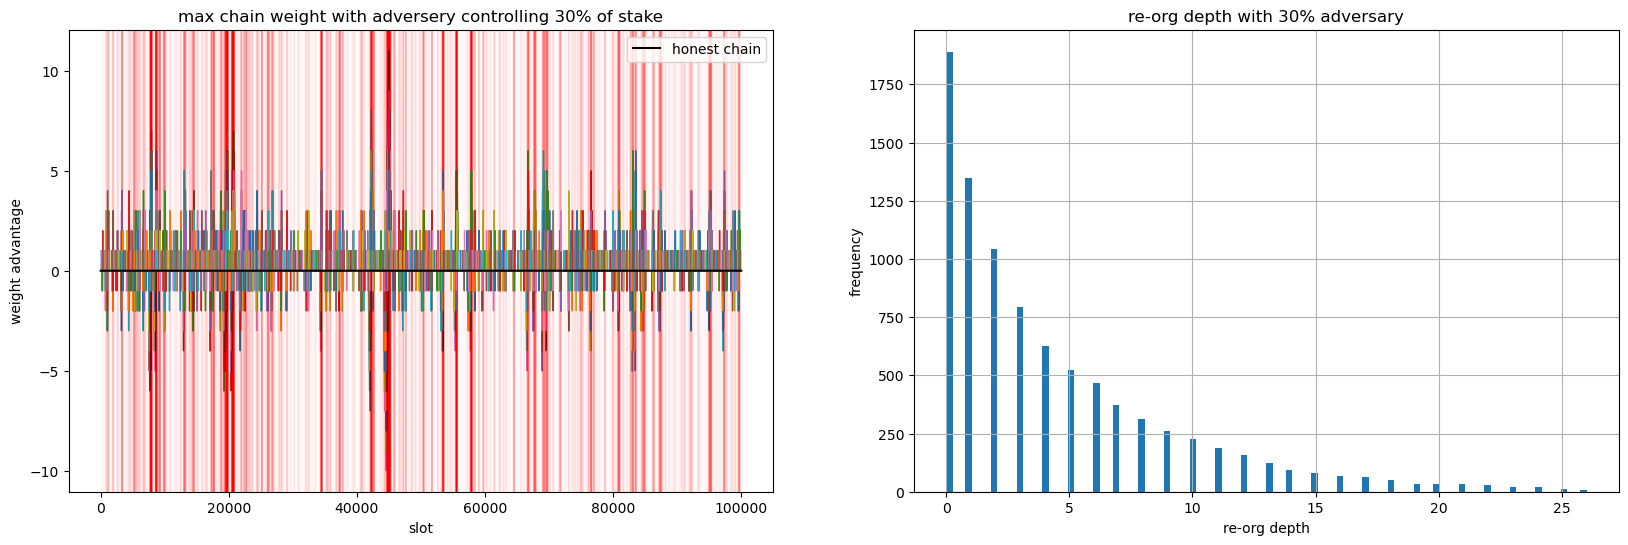

In [274]:
reorgs = sim.adverserial_analysis()

In [277]:
print(len(reorgs[reorgs > 10]) / sim.params.SLOTS)

0.01013


In [10]:
np.random.seed(0)
stake = np.random.pareto(10, 100)

sims = [Sim(
    params=Params(
        SLOTS=100000,
        f=0.05,
        adversary_control = i,
        honest_stake = stake
    ),
    network=NetworkParams(
        mixnet_delay_mean=10, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=2, # second
        pol_proof_time=10, # seconds
        no_network_delay=False
    )
) for i in np.linspace(1e-3, 0.3, 10)]

for i, sim in enumerate(sims):
    print(f"simulating {i+1}/{len(sims)}")
    sim.run(seed=0)

print("finished simulation, starting analysis")
advs = [sim.adverserial_analysis(should_plot=False) for sim in sims]

simulating 1/10
simulating 2/10
simulating 3/10
simulating 4/10
simulating 5/10
simulating 6/10
simulating 7/10
simulating 8/10
simulating 9/10
simulating 10/10
finished simulation, starting analysis


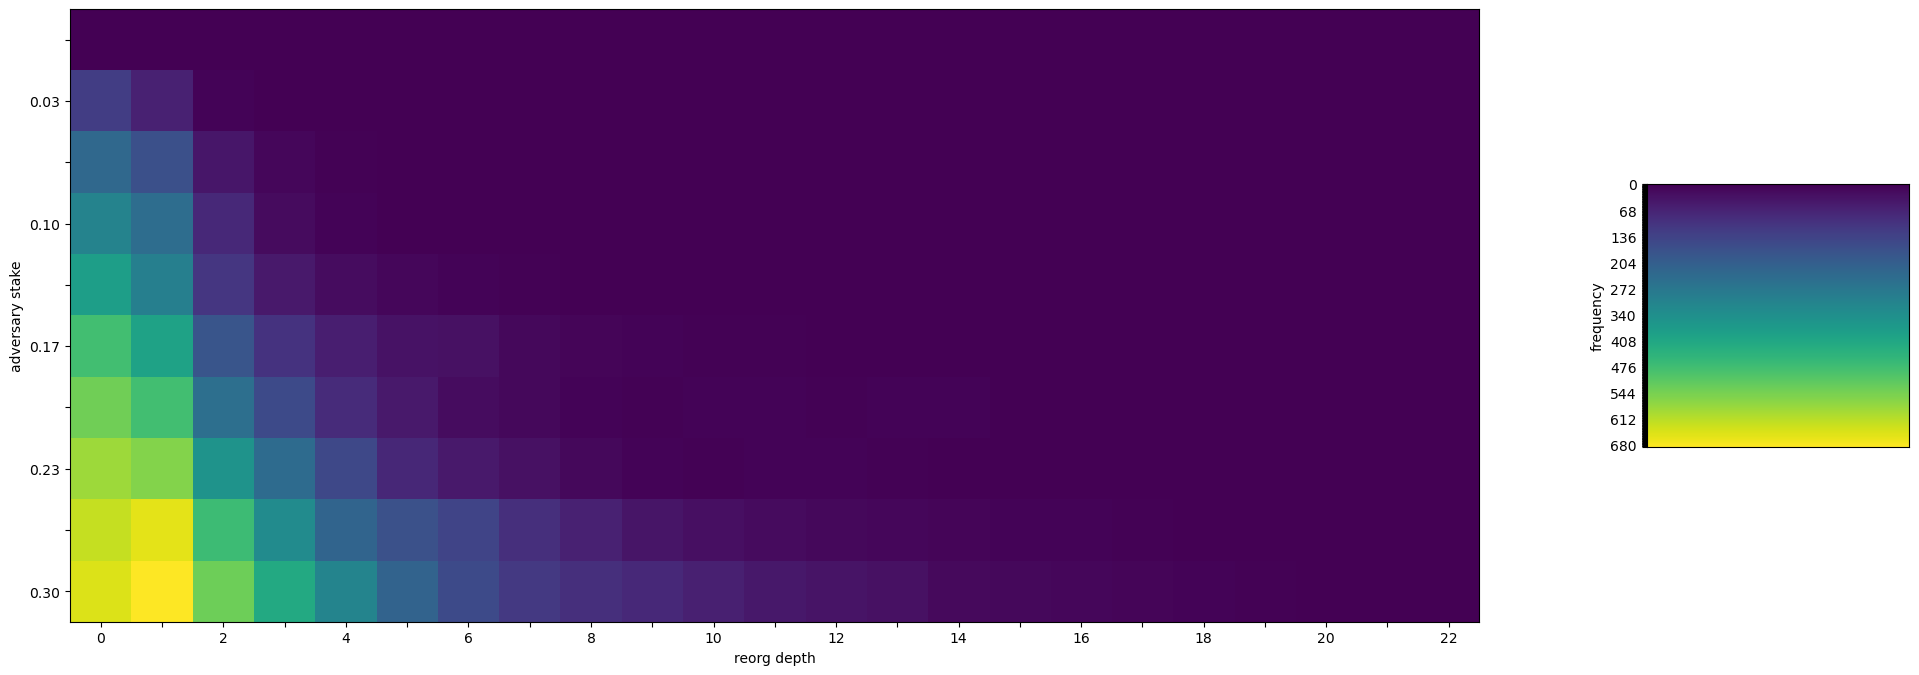

In [11]:
max_reorg_depth = max(a.max() if len(a) > 0 else 0 for a in advs)


heatmap = np.zeros((len(advs), max_reorg_depth), dtype=np.int64)

for i,  adv in enumerate(advs):
    for depth in range(max_reorg_depth):
        heatmap[i][depth] = (adv == depth).sum()

plt.figure(figsize=(40,40))
ax = plt.subplot(121)
im = ax.imshow(heatmap)

_ = ax.set_yticks(np.arange(len(sims)), labels=[f"{s.params.adversary_control:.2f}" if i % 2 == (len(sims) - 1) % 2 else None for i, s in enumerate(sims)])
_ = ax.set_xticks(np.arange(max_reorg_depth), labels=[r if r % (max_reorg_depth // 10) == 0 else None for r in range(max_reorg_depth)])
_ = ax.set_xlabel("reorg depth")
_ = ax.set_ylabel("adversary stake")

ax = plt.subplot(1,10,6)
scale = heatmap.max()
ax.imshow(np.arange(scale+1).reshape((1, scale+1)).T, extent=(1,0,1,0))
_ = ax.set_yticks(np.arange(scale+1) / scale, labels = [r if r % (scale // 10) == 0 else None for r in range(scale+1)])
_ = ax.set_xticks([], minor=False)
_ = ax.set_ylabel("frequency")